# Flight Cancellation

## Import Libraries & Load Data

In [58]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier


We'll load the three datasets: flights.csv, airports.csv, and airlines.csv.

In [9]:
# Load datasets
flights = pd.read_csv("/Users/mu7annad.0gmail.com/Documents/GitHub/we/Machine Learning Exam/DataSet/Flight Cancellation/flights.csv")
airports = pd.read_csv("/Users/mu7annad.0gmail.com/Documents/GitHub/we/Machine Learning Exam/DataSet/Flight Cancellation/airports.csv")
airlines = pd.read_csv("/Users/mu7annad.0gmail.com/Documents/GitHub/we/Machine Learning Exam/DataSet/Flight Cancellation/airlines.csv")

In [10]:
# Standardize column names
flights.columns = flights.columns.str.lower()
airlines.columns = airlines.columns.str.lower()
airports.columns = airports.columns.str.lower()

## Initial Data Inspection

In [11]:
# Display column names
flights.columns

Index(['month', 'day', 'airline', 'flight_number', 'tail_number',
       'origin_airport', 'destination_airport', 'scheduled_time',
       'flight_status', 'cancellation_reason', 'air_system_delay',
       'security_delay', 'airline_delay', 'late_aircraft_delay',
       'weather_delay', 'distance'],
      dtype='object')

In [12]:
# Display the shapes
flights.shape

(581746, 16)

In [13]:
# Class distribution of target variable
flights['flight_status'].value_counts()

flight_status
0    570758
1     10988
Name: count, dtype: int64

In [14]:
# Missing values
flights.isnull().sum()

month                       0
day                         0
airline                     0
flight_number               0
tail_number              1428
origin_airport              0
destination_airport         0
scheduled_time              4
flight_status               0
cancellation_reason    570758
air_system_delay       445682
security_delay         445682
airline_delay          445682
late_aircraft_delay    445682
weather_delay          445682
distance                    0
dtype: int64

In [15]:
flights.isnull().sum()*100/flights.shape[0]

month                   0.000000
day                     0.000000
airline                 0.000000
flight_number           0.000000
tail_number             0.245468
origin_airport          0.000000
destination_airport     0.000000
scheduled_time          0.000688
flight_status           0.000000
cancellation_reason    98.111203
air_system_delay       76.611098
security_delay         76.611098
airline_delay          76.611098
late_aircraft_delay    76.611098
weather_delay          76.611098
distance                0.000000
dtype: float64

Insights:
- Severe Class Imbalance: Only 10,988 flights (1.9%) are canceled (flight_status=1), indicating a highly imbalanced dataset.
- Missing Values: Key delay columns (air_system_delay, weather_delay, etc.) have ~445k missing values.

## Data Cleaning & Merging

In [16]:
airports.isnull().sum()

iata_code    0
airport      0
city         0
state        0
country      0
latitude     3
longitude    3
dtype: int64

In [17]:
# Handle missing airport coordinates
airports.dropna(inplace=True)

In [18]:
# Map airline codes to names
airlines_dict = dict(zip(airlines['iata_code'], airlines['airline']))
flights['airline_name'] = flights['airline'].apply(lambda a: airlines_dict[a])

In [19]:
# Merge flight data with airport details
flights1 = pd.merge(flights, airports, left_on='origin_airport', right_on='iata_code', how='left', suffixes=('', '_origin'))
flights1 = pd.merge(flights1, airports, left_on='destination_airport', right_on='iata_code', how='left', suffixes=('', '_destination'))

## Feature Engineering

In [20]:
# Create date-related features
flights1['date'] = pd.to_datetime(flights1[['month', 'day']].assign(year=2020))  # Dummy year
flights1['week_number'] = flights1['date'].dt.strftime('%U')
flights1['dow_name'] = flights1['date'].dt.strftime('%A')

In [21]:
# Categorize seasons
def season_cat(x):
    if x in [12, 1, 2]: return 'winter'
    elif x in [3, 4, 5]: return 'spring'
    elif x in [6, 7, 8]: return 'summer'
    return 'autumn'
flights1['season'] = flights1['month'].apply(season_cat) 

In [26]:
# Create route identifier
flights1['route'] = flights1['origin_airport'] + '-' + flights1['destination_airport']

In [27]:
def dist_cat(x):
    if x < 500:
        return 'short'
    elif 500 <= x <= 1000:
        return 'medium'
    return 'long'

#create dist type column and count # of short/med/long flights
flights1['distance_type'] = flights1['distance'].apply(dist_cat) 
flights1['distance_type'].value_counts()

distance_type
short     229934
medium    182562
long      169250
Name: count, dtype: int64

## Exploratory Data Analysis (Plots)

/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


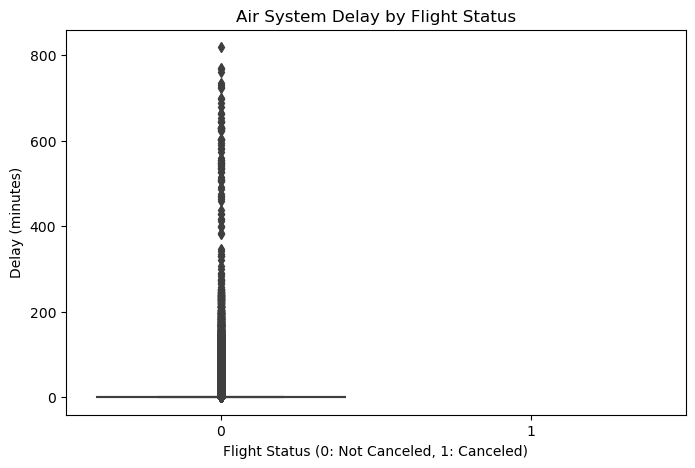

In [28]:
# Plot 1: Air System Delay by Flight Status
plt.figure(figsize=(8, 5))
sns.boxplot(data=flights, x='flight_status', y='weather_delay')
plt.title('Air System Delay by Flight Status')
plt.xlabel('Flight Status (0: Not Canceled, 1: Canceled)')
plt.ylabel('Delay (minutes)')
plt.show()

/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_

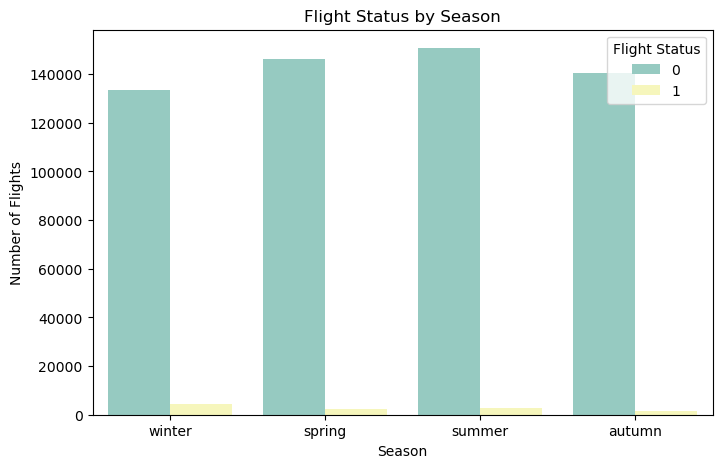

In [29]:
# Plot 2: Flight Status by Season
plt.figure(figsize=(8, 5))
sns.countplot(data=flights1, x='season', hue='flight_status', palette='Set3')
plt.title('Flight Status by Season')
plt.xlabel('Season')
plt.ylabel('Number of Flights')
plt.legend(title='Flight Status')
plt.show()

Winter has the highest cancellation rate

/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


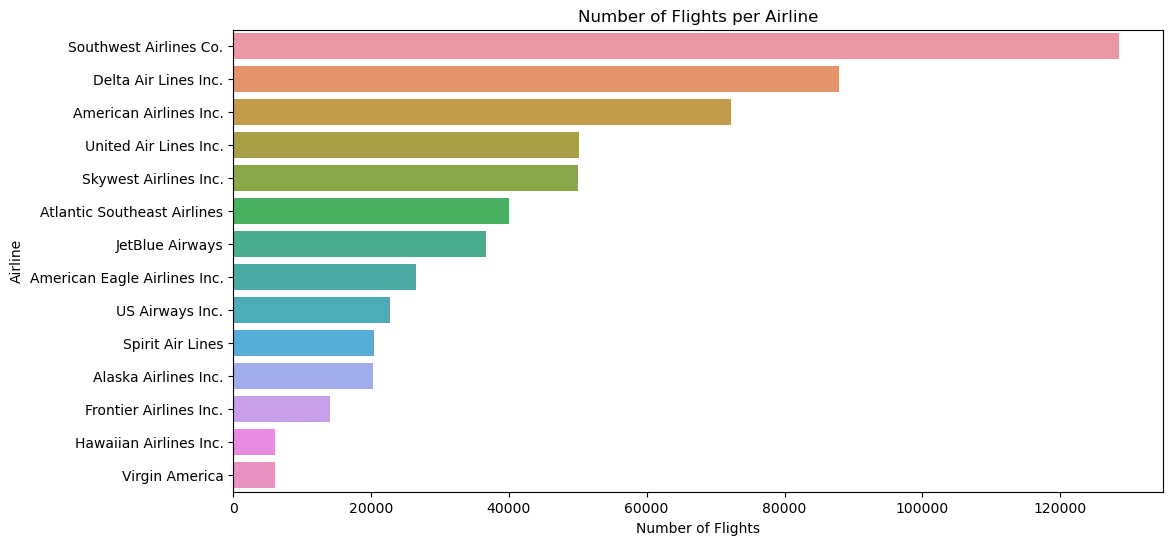

In [30]:
# Plot 3: Number of Flights per Airline
plt.figure(figsize=(12, 6))
sns.countplot(data=flights1, y='airline_name', order=flights1['airline_name'].value_counts().index)
plt.title('Number of Flights per Airline')
plt.xlabel('Number of Flights')
plt.ylabel('Airline')
plt.show()

Southwest Airlines operates the most flights, followed by Delta and American Airlines.

/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


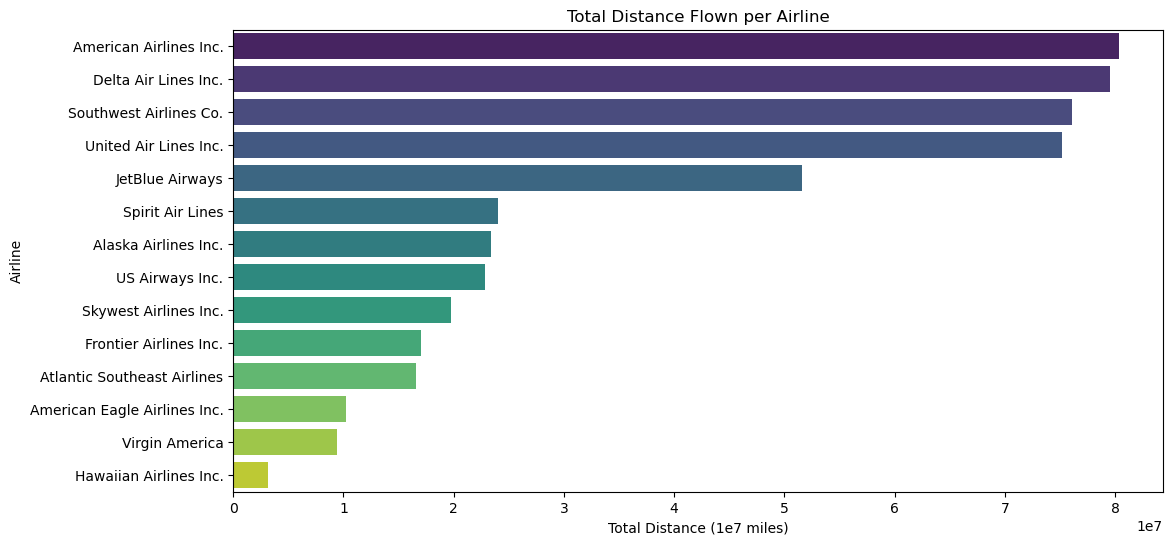

In [31]:
# Plot 4: Total Distance Flown per Airline
distance_sum = flights1.groupby('airline_name')['distance'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=distance_sum.values, y=distance_sum.index, palette='viridis')
plt.title('Total Distance Flown per Airline')
plt.xlabel('Total Distance (1e7 miles)')
plt.ylabel('Airline')
plt.show()

/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


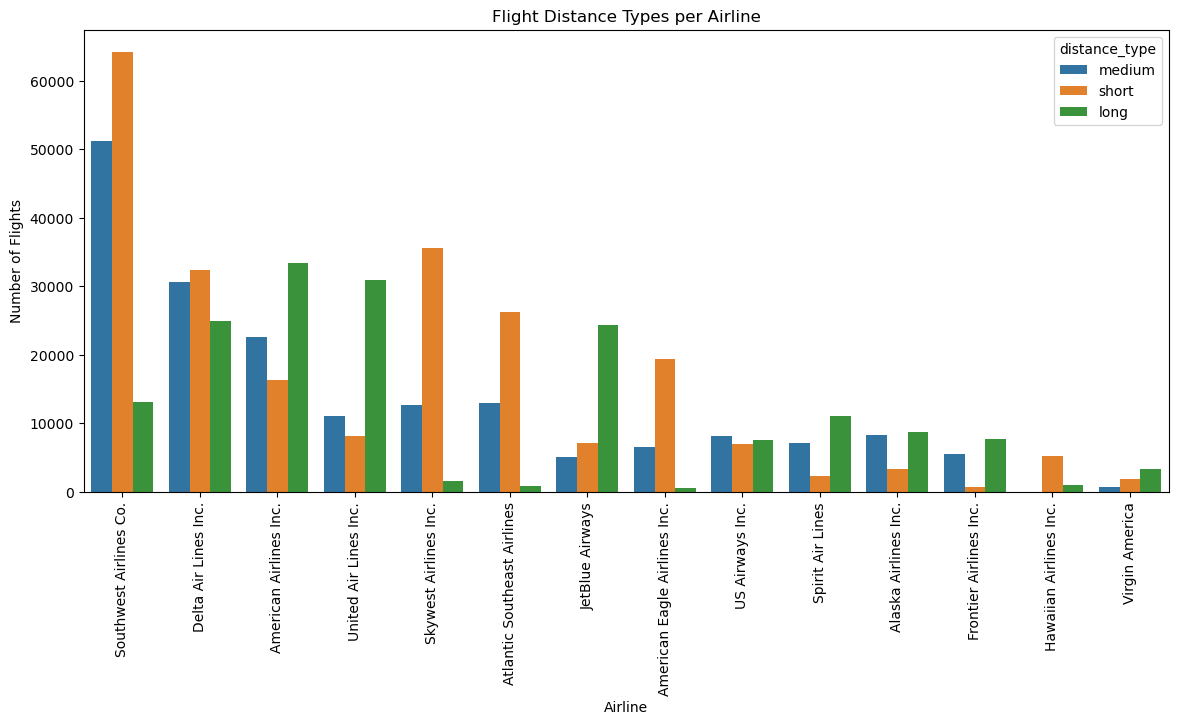

In [32]:
# Plot 5: Flight Distance Types per Airline
plt.figure(figsize=(14, 6))
sns.countplot(data=flights1, x='airline_name', hue='distance_type', order=flights1['airline_name'].value_counts().index)
plt.title('Flight Distance Types per Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.xticks(rotation=90)
plt.show()

/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


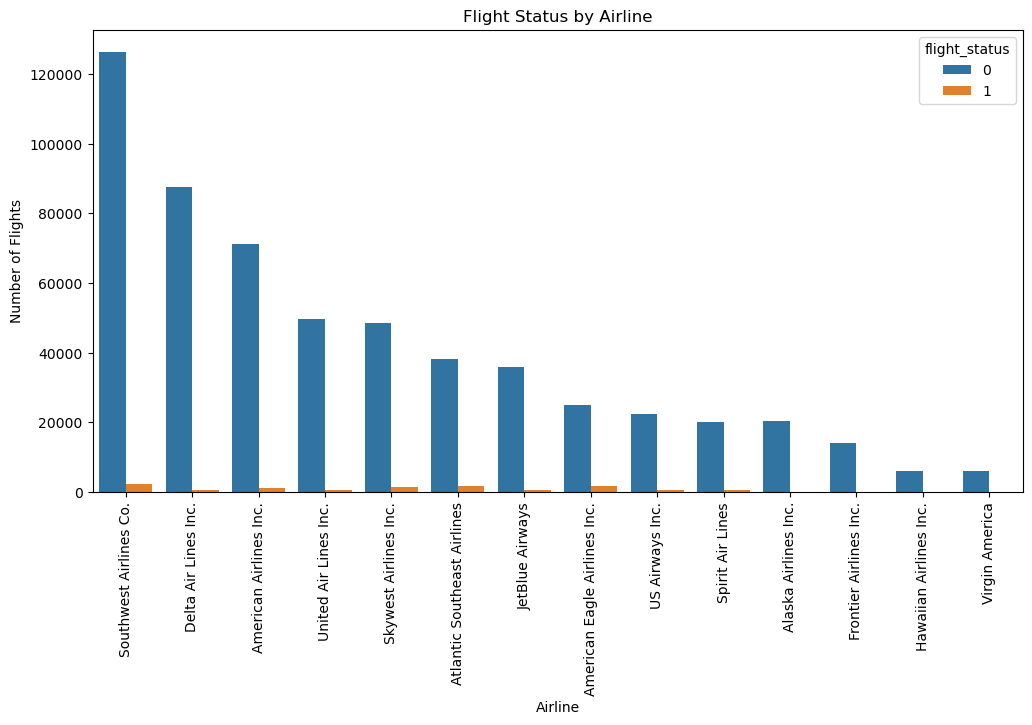

In [33]:
# Plot 6: Flight Status by Airline
plt.figure(figsize=(12, 6))
sns.countplot(data=flights1, x='airline_name', hue='flight_status', order=flights1['airline_name'].value_counts().index)
plt.title('Flight Status by Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.xticks(rotation=90)
plt.show()

/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_

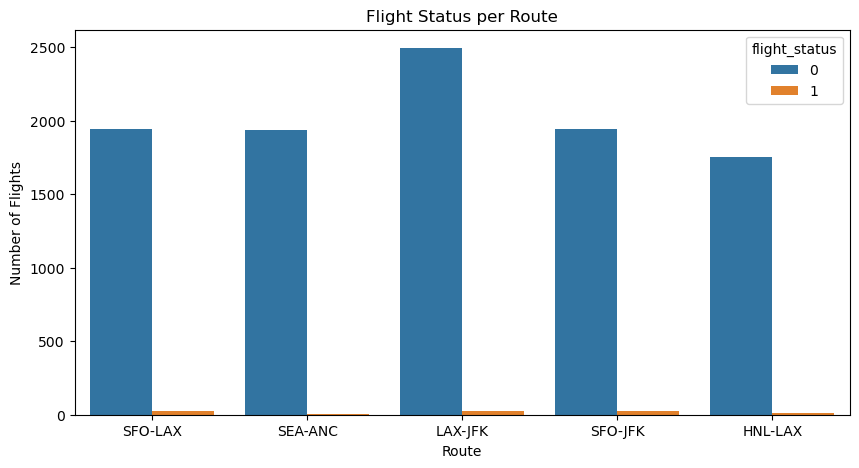

In [34]:
# Plot 7: Flight Status per Route
top_routes = ['LAX-JFK', 'SFO-JFK', 'SFO-LAX', 'SEA-ANC', 'HNL-LAX']
subset = flights1[flights1['route'].isin(top_routes)]
plt.figure(figsize=(10, 5))
sns.countplot(data=subset, x='route', hue='flight_status')
plt.title('Flight Status per Route')
plt.xlabel('Route')
plt.ylabel('Number of Flights')
plt.show()

/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mu7annad.0gmail.com/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


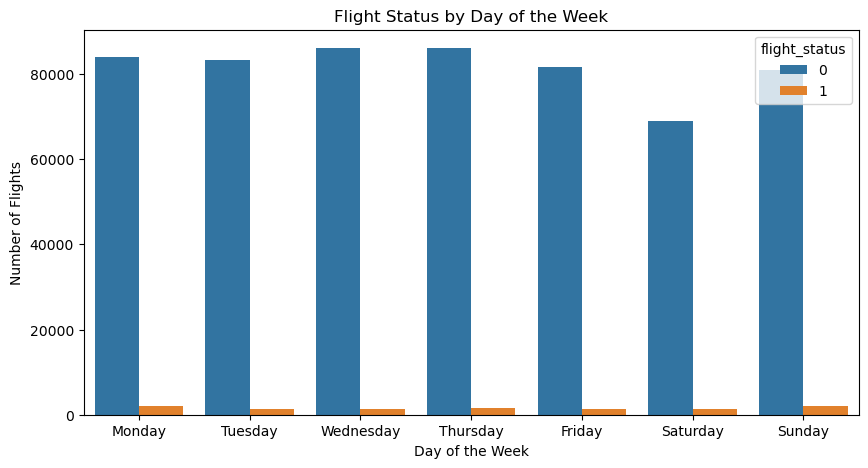

In [35]:
# Plot 8: Flight Status by Day of the Week
plt.figure(figsize=(10, 5))
sns.countplot(data=flights1, x='dow_name', hue='flight_status', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Flight Status by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Flights')
plt.show()


## Final Data Preparation

In [36]:
# Drop columns
flights = flights.drop(columns=[
    'flight_number', 'tail_number', 'cancellation_reason', 
    'air_system_delay', 'security_delay', 'airline_delay', 
    'late_aircraft_delay', 'weather_delay', 'scheduled_time'
])

In [37]:
# Add engineered features from flights1
flights['route'] = flights1['route']
flights['distance_type'] = flights1['distance_type']
flights['season'] = flights1['season']
flights['dow_name'] = flights1['dow_name']
flights['month'] = flights['month'].apply(lambda x: calendar.month_name[x])

In [38]:
# Verify dataset integrity
print("\nMissing Values After Cleaning:\n", flights.isnull().sum())
print("\nFinal Dataset Info:")
flights.info()


Missing Values After Cleaning:
 month                  0
day                    0
airline                0
origin_airport         0
destination_airport    0
flight_status          0
distance               0
airline_name           0
route                  0
distance_type          0
season                 0
dow_name               0
dtype: int64

Final Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581746 entries, 0 to 581745
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   month                581746 non-null  object
 1   day                  581746 non-null  int64 
 2   airline              581746 non-null  object
 3   origin_airport       581746 non-null  object
 4   destination_airport  581746 non-null  object
 5   flight_status        581746 non-null  int64 
 6   distance             581746 non-null  int64 
 7   airline_name         581746 non-null  object
 8   route            

## Model Training Pipeline

In [54]:
# Define features and target
x_cols = ["month", "airline_name", "distance", "route", "season", "dow_name"]
X = flights[x_cols]
y = flights["flight_status"]

In [55]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Custom Frequency Encoder
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.freq_map_ = {}

    def fit(self, X, y=None):
        X = pd.Series(X.ravel())  # Ensure it's a 1D Series
        self.freq_map_ = X.value_counts(normalize=True).to_dict()
        return self

    def transform(self, X):
        X = pd.Series(X.ravel())
        return X.map(self.freq_map_).fillna(0).to_frame()

# Define columns
num_cols = ["distance"]
onehot_cat_cols = ["month", "airline_name", "season", "dow_name"]
route_col = ["route"]

# Pipelines
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

route_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    FrequencyEncoder()
)

# Final Preprocessing
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, onehot_cat_cols),
    ("route", route_pipeline, route_col)
])


In [56]:
# Logistic Regression model
lg_pipe = make_pipeline(preprocessing, LogisticRegression())
lg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['distance']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'airline_name',
                                                   'season', 'dow_name']),
                                                 ('route',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('frequencyencoder',
                                                                   FrequencyEncoder())]),
                                                  ['route'])])),
                ('logisticregression', LogisticRegression())])

In [44]:
# Random Forest model
rf_pipe = make_pipeline(preprocessing, RandomForestClassifier())
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['distance']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'airline_name',
                                                   'season', 'dow_name'])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [45]:
# XGBoost Model
xgb_pipe = make_pipeline(preprocessing, XGBClassifier())
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['distance']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'airli...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

## Model Evaluation

In [47]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

Test Dataset Accuracy: 0.9773957885689729


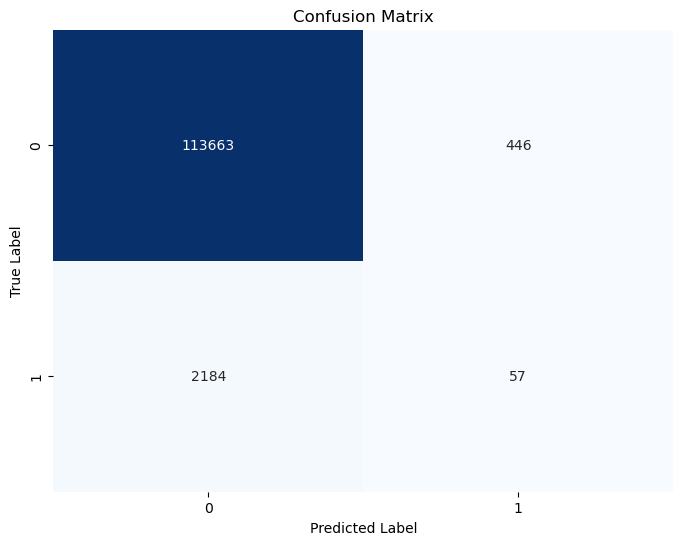

In [48]:
# Random Forest
y_pred = rf_pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Dataset Accuracy: {acc}")

plot_confusion_matrix(y_test, y_pred)

Test Dataset Accuracy: 0.9807391491190374


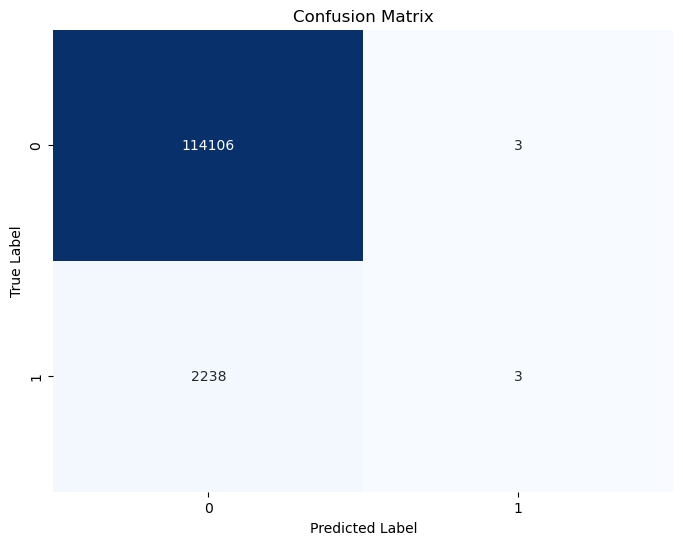

In [354]:
# XGBoost
y_pred = xgb_pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Dataset Accuracy: {acc}")

plot_confusion_matrix(y_test, y_pred)

Test Dataset Accuracy: 0.9807391491190374


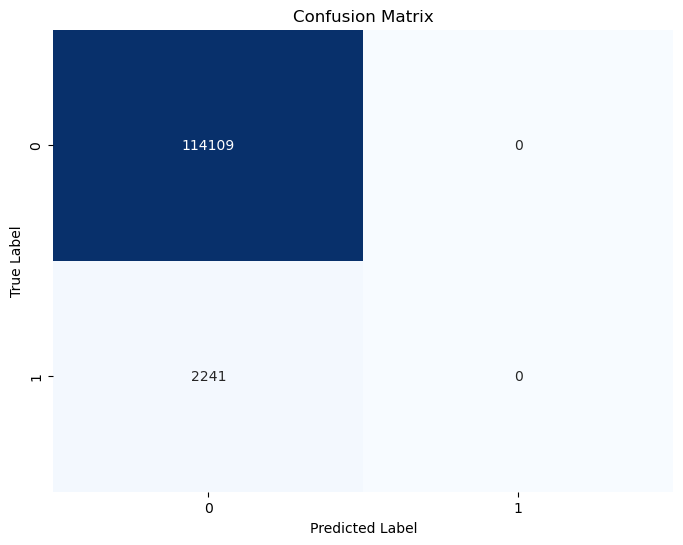

In [57]:
# Logistic Regression 
y_pred = lg_pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Dataset Accuracy: {acc}")

plot_confusion_matrix(y_test, y_pred)

## Summary

The model has a hard time discerning which flights would be cancelled due to critical limitations:
1. Class Imbalance Dominates Performance

    Only 1.9% of flights are canceled (flight_status=1), leading the model to prioritize majority-class accuracy.
